AR anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates composites for difference indices (e.g. Type 1 El Nino)


## Imports

In [26]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df
from statistical_tests import xr_ttest_ind_from_stats, ttest_1samp_new

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_anom']
plot_dict_ivt = config['ivt_anom']
plot_dict_prec = config['precip_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### AR days

In [6]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

def mjo_index(ref, start_date, end_date):
    '''create a pandas df of the Madden Julian Oscillation index 
    on daily, monthly, or seasonal timescale 
    with yes MJO phase as positive, no MJO phase as negative
    '''
    fname_daily = path_to_data + 'teleconnection_indices/mjo.events.ouu.1979.2019.txt'
    df = pd.read_csv(fname_daily, delim_whitespace=True, engine='python')
    df['date'] = pd.date_range('1979-01-01 9:00:00', '2019-12-31 9:00:00', freq='1D')
    df = df.set_index('date')
    
    if ref == 'daily':
        # (yes MJO) positive = 1, (no MJO) negative = -1
        df['COND'] = 0
        idx = (df['PHA']>0) & (df['AMPLITUDE']>1)
        df.loc[idx, 'COND'] = 1
        df.loc[df['PHA']==0, 'COND'] = -1

    elif ref == 'monthly':
        print('No monthly capabilities yet')
        
    elif ref == 'seasonal':
        print('No seasonal capabilities yet')
    
    # trim to start_date, end_date
    idx = (df.index >= start_date) & (df.index <= end_date + " 23:59:59")
    df = df.loc[idx]
        
    return df

### Climate Indices

In [7]:
start_date = '1979-12-01'
end_date = '2019-05-31'
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
tele_mon = build_teleconnection_df('monthly', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
tele

,AO,PDO,ENSO,SH,MJO
date,,,,,
1979-12-01 09:00:00,1,0,0,0,1
1979-12-02 09:00:00,1,0,0,0,1
1979-12-03 09:00:00,1,0,0,0,1
1979-12-04 09:00:00,1,0,0,0,1
1979-12-05 09:00:00,1,0,0,0,1
...,...,...,...,...,...
2019-05-27 09:00:00,0,0,1,1,1
2019-05-28 09:00:00,-1,0,1,1,1
2019-05-29 09:00:00,-1,0,1,1,1


In [8]:
tele_mon = select_months(tele_mon, 12, 5)
tele_mon

,AO,PDO,ENSO,SH
date,,,,
1979-12-01,1,0,0,0
1980-01-01,-1,0,0,0
1980-02-01,-1,1,0,0
1980-03-01,-1,1,0,0
1980-04-01,-1,1,0,0
...,...,...,...,...
2019-01-01,-1,0,1,1
2019-02-01,1,-1,1,1
2019-03-01,1,0,1,1


In [9]:
df_index = select_months(tele, 12, 5)
df = ar_daily_df(ssn, nk)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


### ERA5 renalysis

In [10]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []

# Select lat/lon grid
lonmin = 20.
lonmax = 110
latmin = 10
latmax = 50

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))


In [11]:
uvec = f[1]['p71.162'].values
vvec = f[1]['p72.162'].values
ivt = np.sqrt(uvec**2 + vvec**2)

var_dict = {'H': (['time', 'lat', 'lon'], (f[0]['z'].values/(9.80665))), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values),
            'ivt': (['time', 'lat', 'lon'], ivt)}


ds1 = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds1
print('ds size in GB {:0.2f}\n'.format(ds1.nbytes / 1e9))

ds_lst = [ds1, ds2]

ds size in GB 10.54



In [13]:
# import precipitation averages for AR Types
fname = path_to_out+'precip_djfmam_h500_eof2_k3.nc'
precipitation = xr.open_dataset(fname)
precipitation

<xarray.Dataset>
Dimensions:  (ar: 3, lat: 221, lon: 361)
Coordinates:
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float32 20.0 20.25 20.5 20.75 ... 109.25 109.5 109.75 110.0
  * ar       (ar) int64 1 2 3
Data variables:
    prec     (ar, lat, lon) float64 ...

### Combine with data

In [14]:
df = new_df
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    ds_lst[i] = ds

### Compute AR Composites

In [40]:

cond_lst1 = [1, 0, -1]*3
cond_lst2 = ['ENSO']*3 + ['AO']*3 + ['SH']*3
# cond_lst1 = [1, -1]*3 + [1, 0]
# cond_lst2 = ['ENSO']*2 + ['AO']*2 + ['SH']*2 + ['MJO']*2

data_lst = []
tval_lst = []

for i, (cond1, cond2) in enumerate(zip(cond_lst1, cond_lst2)):
    ds = ds_lst[0]
    print(cond2, cond1)
    idx = (ds[cond2] == cond1)
    ds = ds.sel(time=idx)
    
    # repeat for each AR Type Grouping
    for k in np.arange(1, nk+1, 1):
        print('AR Type ', k)
        idx = (ds['AR_CAT'] == k)
        tmp_ar = ds.sel(time=idx)
        popmean = np.zeros([len(ds.lat), len(ds.lon)])
#         print(tmp_ar)

        # calculate number of independent events - simply the number of years conditions are true
#         idx = (tele_mon[cond2] == cond1)
#         nevents = tele_mon[idx].index.year.nunique()
#         print(nevents)
        nevents = len(np.unique(tmp_ar.time.dt.year.values))
        print(nevents)
        # calculate t-value based on nevents
        a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
        data_lst.append(a_mean)
        tval_lst.append(tval_mask)

ENSO 1
AR Type  1
15
AR Type  2
15
AR Type  3
16
ENSO 0
AR Type  1
27
AR Type  2
30
AR Type  3
30
ENSO -1
AR Type  1
12
AR Type  2
13
AR Type  3
12
AO 1
AR Type  1
26
AR Type  2
27
AR Type  3
36
AO 0
AR Type  1
30
AR Type  2
29
AR Type  3
30
AO -1
AR Type  1
23
AR Type  2
33
AR Type  3
22
SH 1
AR Type  1
15
AR Type  2
16
AR Type  3
19
SH 0
AR Type  1
15
AR Type  2
13
AR Type  3
14
SH -1
AR Type  1
20
AR Type  2
18
AR Type  3
18


### Figures

### Common Plot Properties

In [41]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


### Composite Plots - ENSO, AO, SH

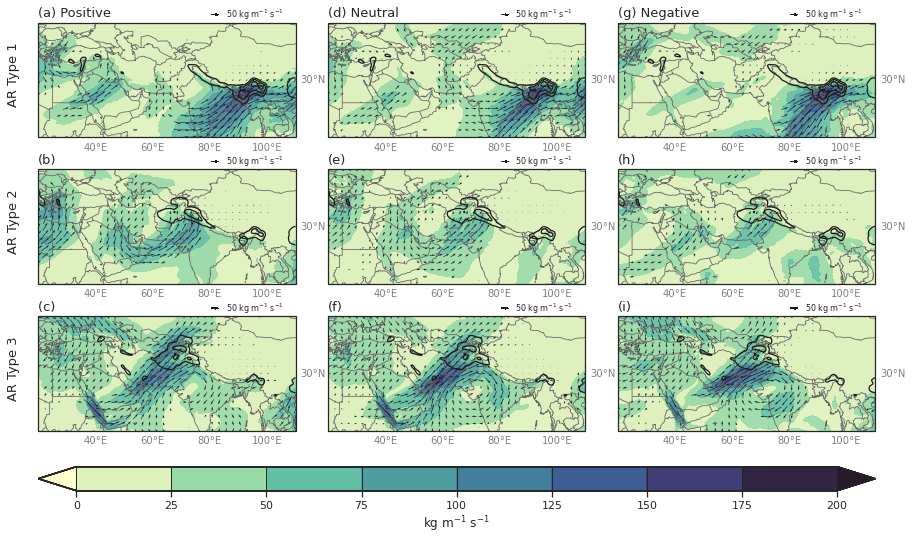

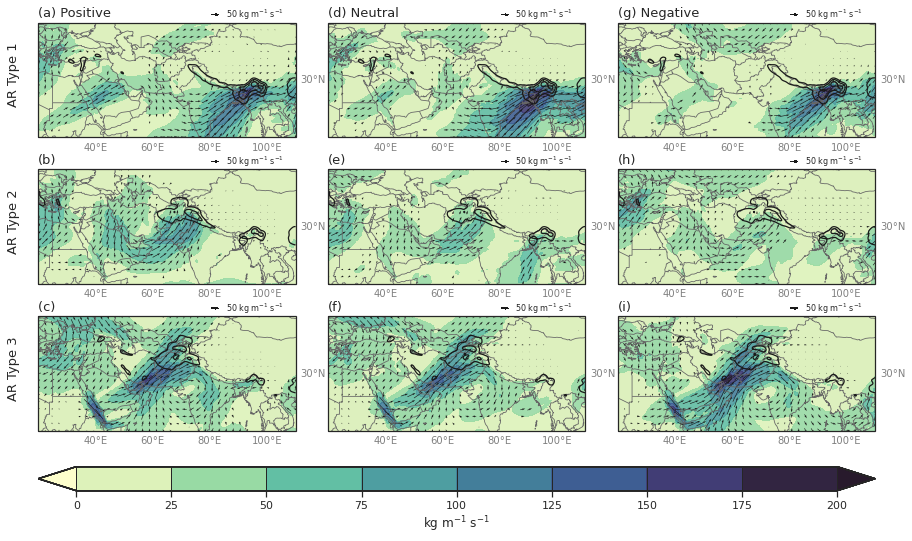

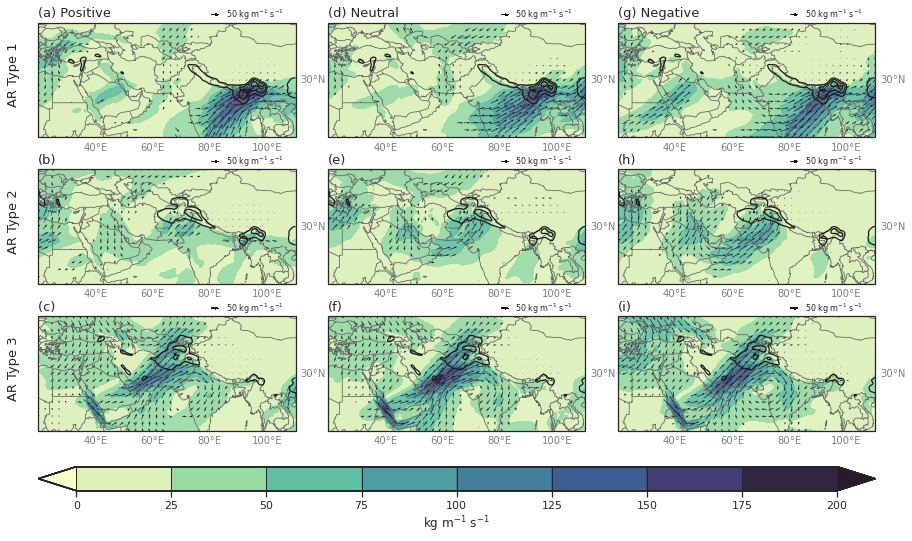

In [44]:
plot_ds = [data_lst[:9], data_lst[9:18], data_lst[18:]]
tval_ds = [tval_lst[:9], tval_lst[9:18], tval_lst[18:]]
names = ['ENSO', 'AO', 'SH']
artype_lst = [1, 2, 3]*3 
for i, cliindex in enumerate(names):
    diff_data = plot_ds[i]
    tval_data = tval_ds[i]
    filepath = fig_path + 'composite_ivt_' + cliindex + '.png'
    nrows = nk
    ncols = 3
    sig_level = 0.05
    sig_level = True
    row_lbl = ['AR Type 1'] + ['AR Type 2'] + ['AR Type 3'] + ['']*6
    col_lbl = ['(a) Positive', '(b)', '(c) ',
               '(d) Neutral', '(e)','(f)',
               '(g) Negative', '(h)', '(i)']
    
    # Create figure
    fig = plt.figure(figsize=(15, 10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='7%',label_mode='',
                    direction='column')
    for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
        data = diff_data[k]
        tval = tval_data[k]
        plot_dict = plot_dict_ivt
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.ivte.values
        vvec = data.ivtn.values
#         ivt = data.ivt.values
        ivt = np.sqrt(uvec**2+vvec**2)

        uvec_mask = data.ivte.where((tval.ivte == True) | (tval.ivtn == True)).values
        vvec_mask = data.ivtn.where((tval.ivte == True) | (tval.ivtn == True)).values
#         ivt_mask = data.ivt.where((tval.ivt == True)).values
        ivt_mask = np.sqrt(uvec_mask**2+vvec_mask**2)

       # Contour Filled (IVT significant)                           
#         cflevs = np.arange(-80, 100, 20)
        cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2]) 
        cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                         levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                              coordinates='axes', fontproperties={'size': 8.0})

        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=ar_type)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)


        # subtitles
        ax.set_title(col_lbl[k], loc='left',fontsize=13)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=13,
            transform=ax.transAxes)

    # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
        cb.set_label('kg m$^{-1}$ s$^{-1}$')

    # Save figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Show
    plt.show()


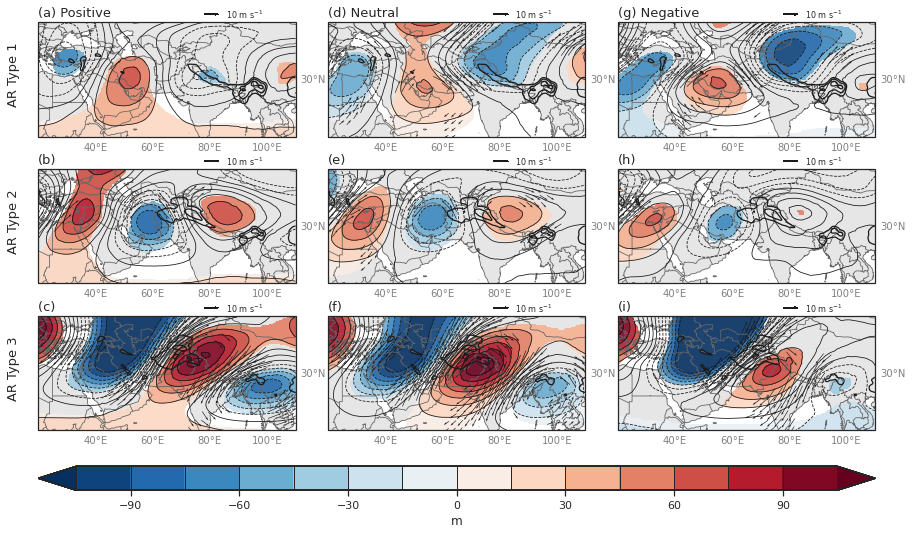

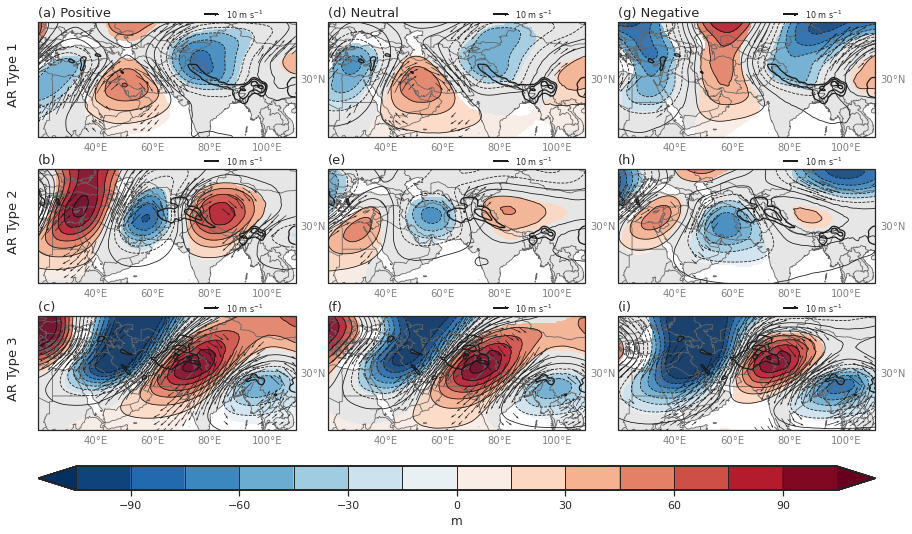

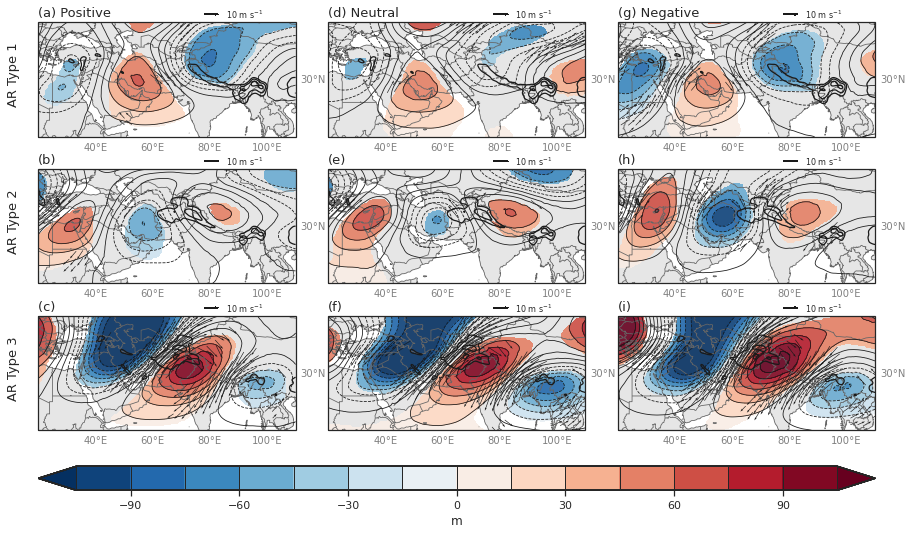

In [45]:
plot_ds = [data_lst[:9], data_lst[9:18], data_lst[18:]]
tval_ds = [tval_lst[:9], tval_lst[9:18], tval_lst[18:]]
names = ['ENSO', 'AO', 'SH']
artype_lst = [1, 2, 3]*3
for i, cliindex in enumerate(names):
    diff_data = plot_ds[i]
    tval_data = tval_ds[i]
    filepath = fig_path + 'composite_upper_' + cliindex + '.png'
    nrows = nk
    ncols = 3
    sig_level = 0.05
    sig_level = True
    row_lbl = ['AR Type 1'] + ['AR Type 2'] + ['AR Type 3'] + ['']*6
    col_lbl = ['(a) Positive', '(b)', '(c) ',
               '(d) Neutral', '(e)','(f)',
               '(g) Negative', '(h)', '(i)']

    # Create figure
    fig = plt.figure(figsize=(15, 10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='7%',label_mode='',
                    direction='column')

    for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
        data = diff_data[k]
        tval = tval_data[k]
        plot_dict = plot_dict_upper
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        uvec = data.U.values
        vvec = data.V.values
        hgts = data.H.values

        uvec_mask = data.U.where((tval.U == True) | (tval.U == True)).values
        vvec_mask = data.V.where((tval.V == True) | (tval.V == True)).values
        hgts_mask = data.H.where((tval.H == True)).values

       # Contour Filled (hgts significant)                           
        cflevs = clevs = np.arange(-105, 110, 15)
        cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                         levels=cflevs, cmap='RdBu_r', alpha=0.9, extend='both') 

        # Wind barbs / vectors
        Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                      color='k', regrid_shape=17, pivot='middle',
                      angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')

        # quiver key
        qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                              coordinates='axes', fontproperties={'size': 8.0})

        # Contour Lines (250-hPa Heights ALL)
#         print(hgts.min(), hgts.max())
        clevs = np.arange(-105, 110, 15)
        cs = ax.contour(lons, lats, hgts, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)
    #     plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 
        
        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=ar_type)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)

        # subtitles
        ax.set_title(col_lbl[k], loc='left',fontsize=13)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=13,
            transform=ax.transAxes)

    # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
        cb.set_label('m')

    # Save figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Show
    plt.show()
